# 전복 나이 예측 경진대회

`-` 참고: https://dacon.io/competitions/official/235877/codeshare/4695?page=1&dtype=recent

## 패키지 import 및 데이터 전처리

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.simplefilter('ignore')

In [25]:
df = pd.read_csv('C:/Users/Jaesu/github_desktop/Dacon-Basic/전복-나이-예측/Data/train.csv')

In [26]:
df.head()

,id,Gender,Lenght,Diameter,Height,Whole Weight,Shucked Weight,Viscra Weight,Shell Weight,Target
0,1,M,0.605,0.470,0.115,1.1140,0.3925,0.2910,0.3100,15
1,2,I,0.430,0.315,0.095,0.3780,0.1750,0.0800,0.1045,8
2,3,I,0.580,0.490,0.195,1.3165,0.5305,0.2540,0.4100,18
3,4,M,0.535,0.405,0.175,1.2705,0.5480,0.3265,0.3370,13
4,5,I,0.310,0.235,0.090,0.1270,0.0480,0.0310,0.0400,6


In [27]:
df.isnull().sum() ## 결측치 확인

id                0
Gender            0
Lenght            0
Diameter          0
Height            0
Whole Weight      0
Shucked Weight    0
Viscra Weight     0
Shell Weight      0
Target            0
dtype: int64

In [28]:
df.drop('id', axis=1, inplace=True) ## id 컬럼 드랍

`-` 13살을 기준으로 young, old로 나누자

In [29]:
df['Age'] = df['Target'].apply(lambda age: 'young' if age <= 13 else 'old') 

## EDA

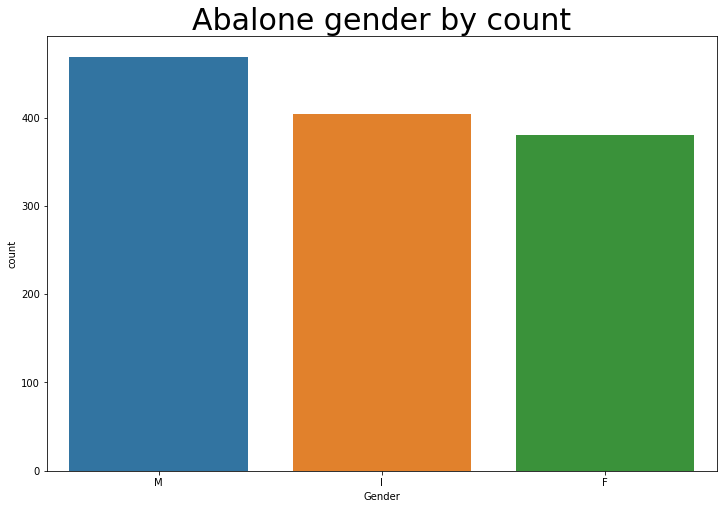

In [6]:
plt.figure(figsize=(12, 8))
sns.countplot('Gender', data=df)
plt.title('Abalone gender by count', fontsize=30)
plt.show()

`-` 전복은 성별이 3개이다(I는 Infant(영유야?))

In [7]:
np.sort(df['Target'].unique())

array([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
       20, 21, 22, 23, 29], dtype=int64)

`-` 나이가 3세 ~ 23세 그리고 29세가 데이터에 존재

`-` 전복 나이의 범주가 많지 않고 값이 연속적으로 나타나므로 빈도 막대를 그리자

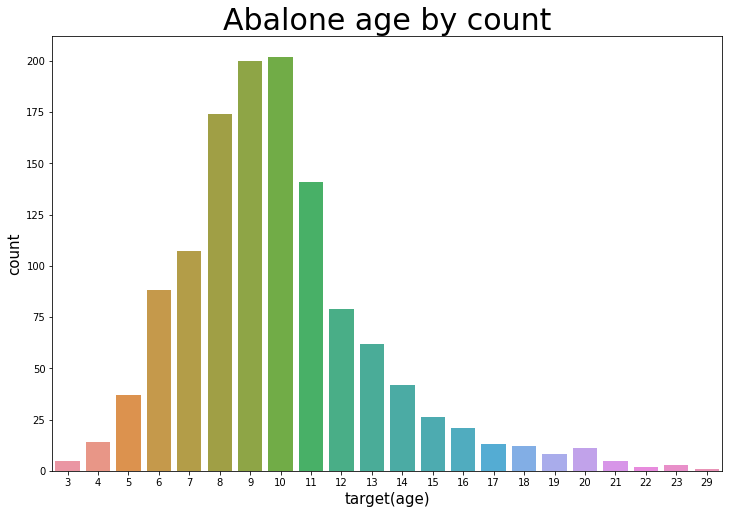

In [9]:
## 전복의 나이 분포 시각화
plt.figure(figsize=(12, 8))
sns.countplot('Target' , data=df)
plt.title('Abalone age by count', fontsize=30)
plt.xlabel('target(age)', fontsize=15)
plt.ylabel('count', fontsize=15)
plt.show()

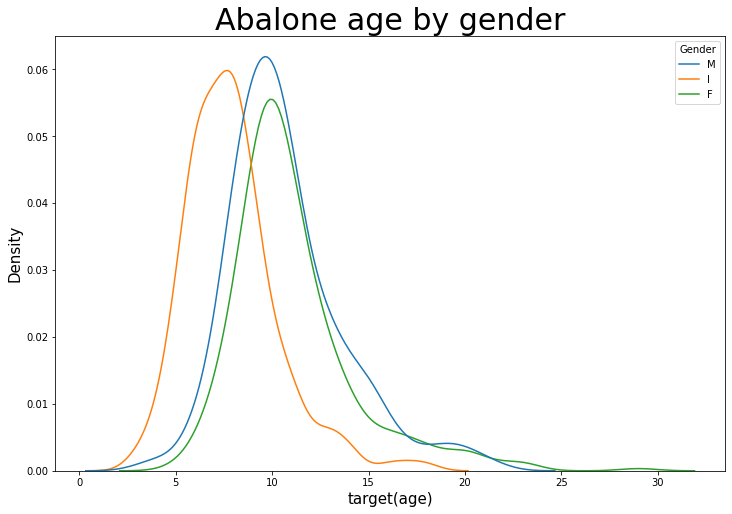

In [10]:
## Gender별 나이의 분포 시각화
plt.figure(figsize=(12, 8))
sns.kdeplot('Target', hue='Gender', data=df)
plt.title('Abalone age by gender', fontsize=30)
plt.xlabel('target(age)', fontsize=15)
plt.ylabel('Density', fontsize=15)
plt.show()

`-` 성별이 I인 경우 나이가 더 어리다

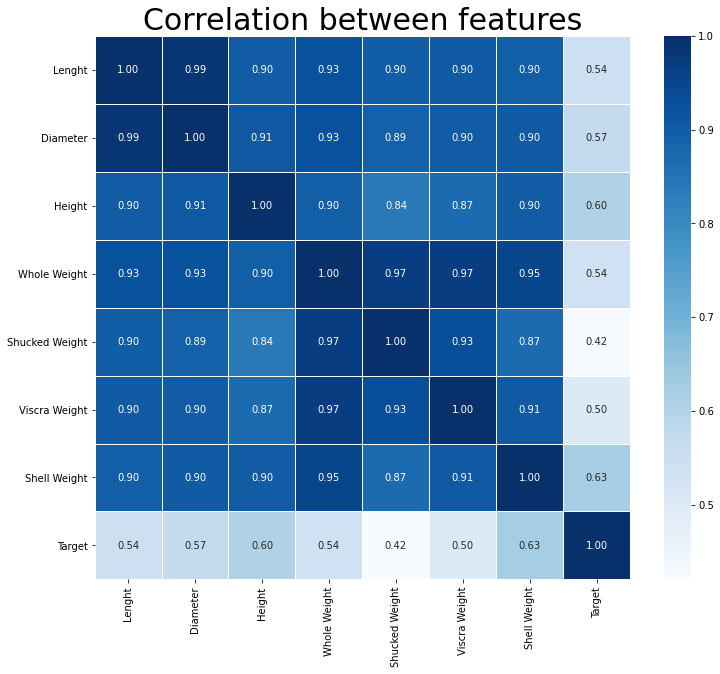

In [46]:
## 수치형 데이터 상관관계 히트맵 시각화
df_ = df.drop('Gender', axis=1)
df_corr = df_.corr(method='pearson')
plt.figure(figsize=(12, 10))
sns.heatmap(data=df_corr, annot=True, fmt='.2f', linewidths=.5, cmap='Blues')
plt.title('Correlation between features', fontsize=30)
plt.show()

`-` 설명변수간의 상관계수가 크다

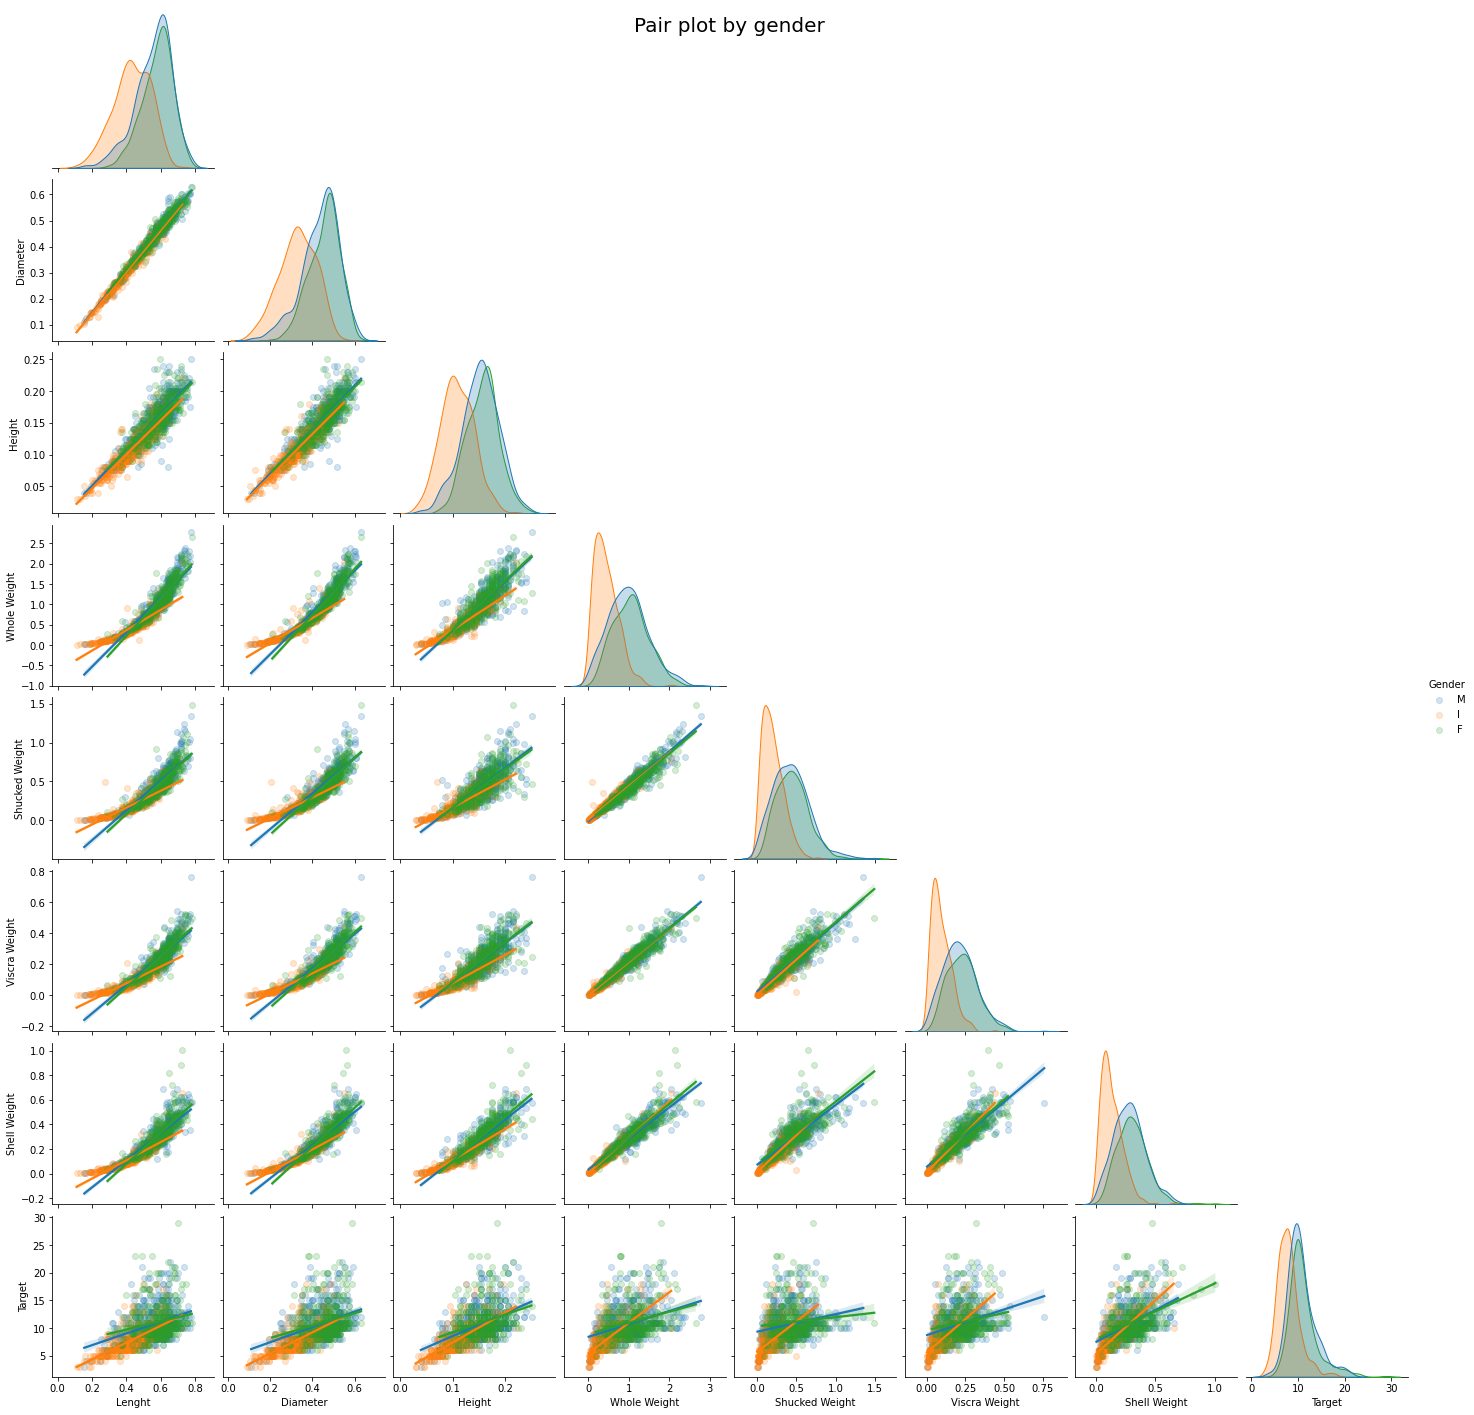

In [57]:
sns.pairplot(df, hue='Gender', kind='reg', corner=True, plot_kws={'scatter_kws': {'alpha': 0.2}})
plt.suptitle('Pair plot by gender', fontsize=20)
plt.show()

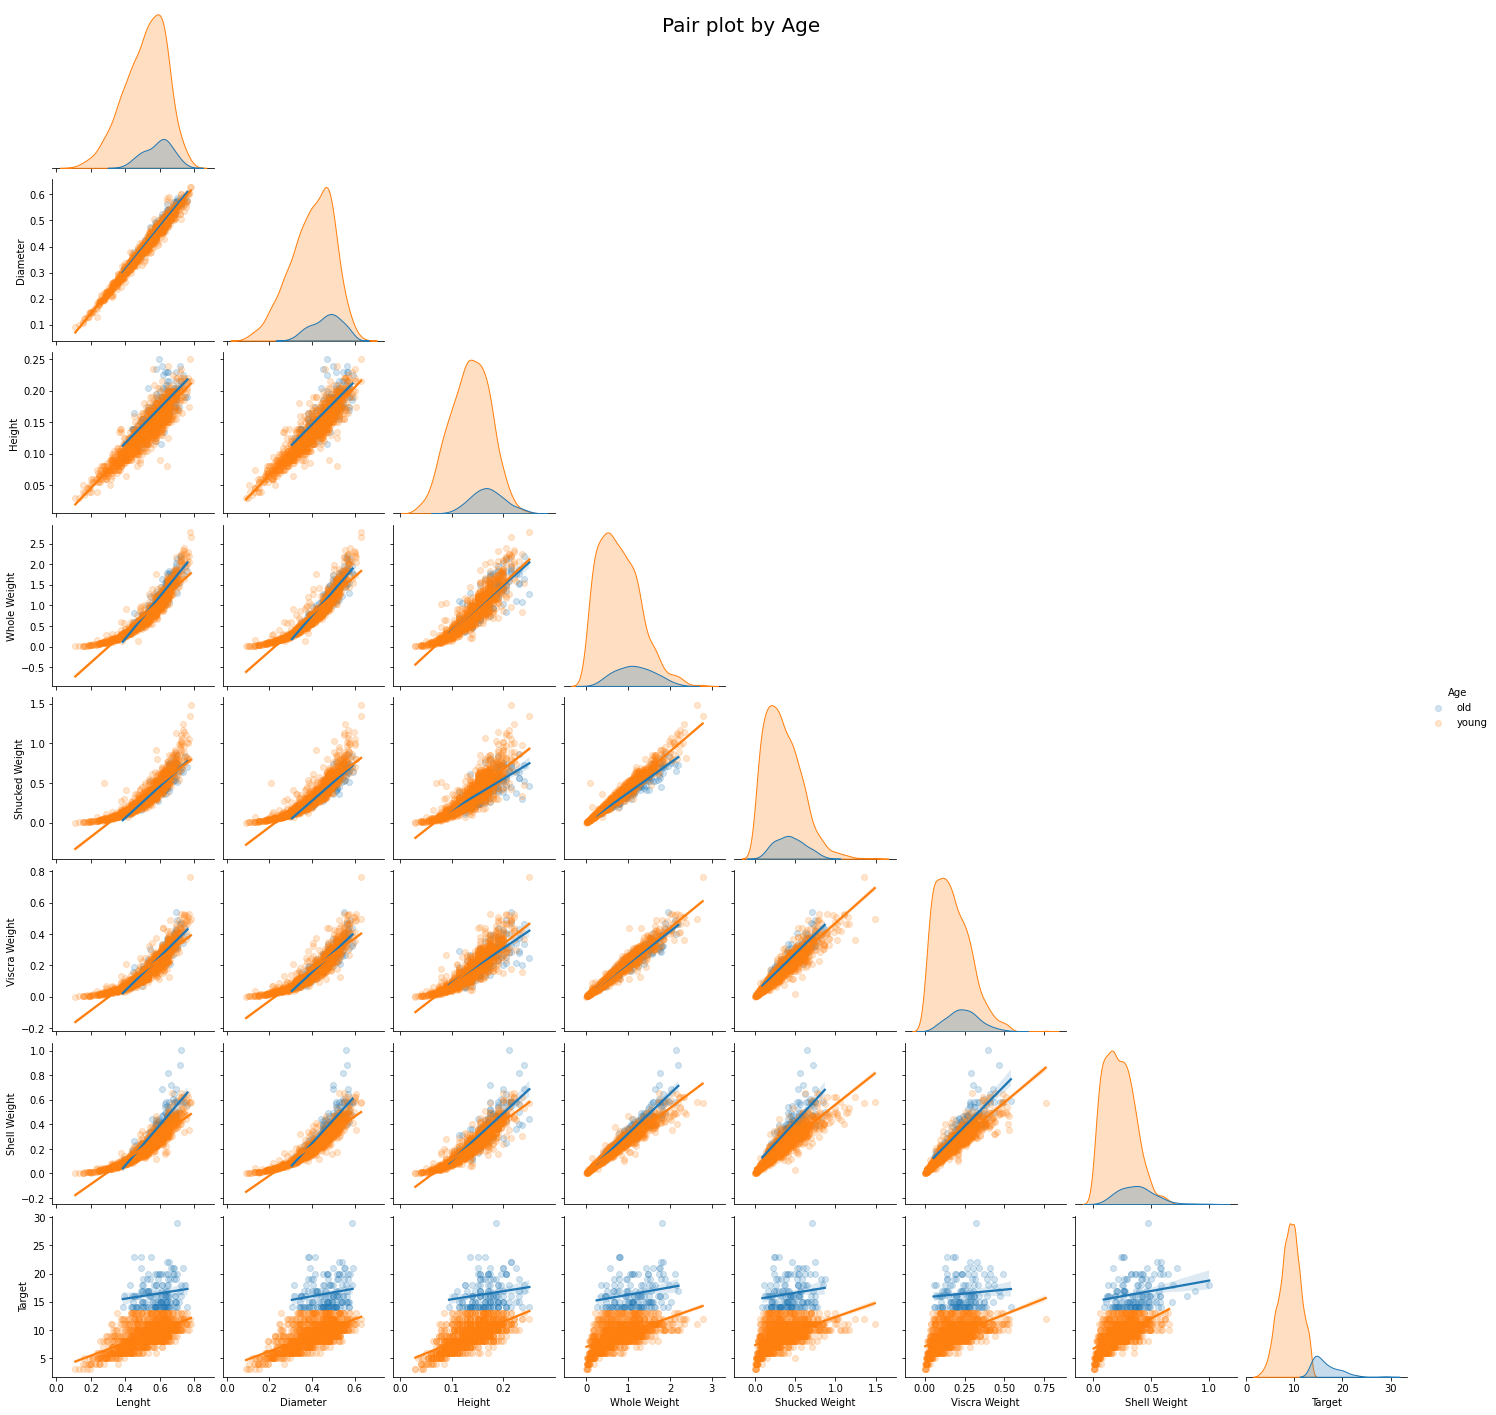

In [31]:
sns.pairplot(df, hue='Age', kind='reg', corner=True, plot_kws={'scatter_kws': {'alpha': 0.2}})
plt.suptitle('Pair plot by Age', fontsize=20)
plt.show()

`-` 위를 보면 13살이 넘어가면 예측하기 힘들 것 같다(군집화 되어있지 않고 겹쳐있다)

## 변수 탐색

|변수 명 |세부 사항|
|:-:|:-:|
|id | 샘플 아이디|
|Gender | 전복 성별|
|Lenght | 전복 길이|
|Diameter | 전복 둘레|
|Height | 전복 키 |
|Whole Weight |전복 전체 무게|
|Shucked Weight | 껍질을 제외한 무게|
|Viscra Weight | 내장 무게|
|Shell Weight | 껍질 무게|
|Target | 전복 나이|

`-` 전복 전체 무게는 다른 무게 변수보다 더 커야한다

`-` 참고로 껍질을 제외한 무게와 껍질 무게를 합해도 전복 전체 무게를 넘지 못하는데

`-` 이는 껍질을 제거하는 과정에서 무게에 손실이 있었다는 의미이다(i.g. 물)

In [34]:
## 공백을 _(언더바)로 바꾼다
def replace_column_blank2underbar(df: pd.DataFrame) -> None:
    df.rename(columns = dict(zip(df.columns, [column.replace(' ', '_') for column in df.columns])), inplace=True) 

In [35]:
replace_column_blank2underbar(df)

In [37]:
df['Shell_Water'] = df['Whole_Weight'] - df['Shucked_Weight'] - df['Shell_Weight'] ## 전복이 머금은 물의 무게

<AxesSubplot:>

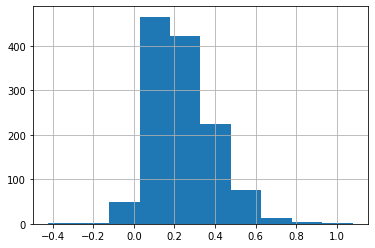

In [40]:
df['Shell_Water'].hist()

`-` 음수인 것은 뭘까?(측정오차?)

In [61]:
df['Weight_Ratio'] =  df['Shucked_Weight'] / df['Whole_Weight'] ## 순수한 전복살 무게 / 전체 전복 무게

<AxesSubplot:>

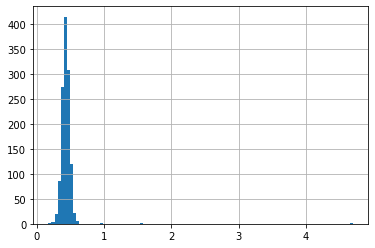

In [62]:
df['Weight_Ratio'].hist(bins = 100)

`-` 전복 크기대비 순살 무게를 구하자

`-` 비율이 4가 넘는 전복은 뭘까?(측정 오류?)

In [47]:
π = 3.141592

`-` 전복모양을 편의상 원이라고 가정하면 아래와 같다

`-` $r = \dfrac{\text{Lenght}}{2\pi} = \dfrac{\text{Diameter}}{2}$

`-` 그런데 원이 아니고 타원이니까 위 둘의 평균을 반지름이라 하고 계산하겠다

In [51]:
df['Radius'] = ((df['Lenght'] / 2*π) + (df['Diameter'] / 2)) / 2

<AxesSubplot:>

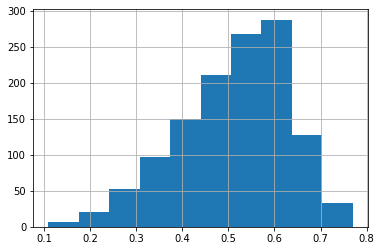

In [54]:
df['Radius'].hist()

In [64]:
## 전복모양을 편의상 원이라고 가정 
df['Density'] = df['Shucked_Weight'] / (3 * (df['Height'] * (df['Radius'] ** 2))) ## 순살 무게 / 면적(반지름^2 * 키 * 1/3)

<AxesSubplot:>

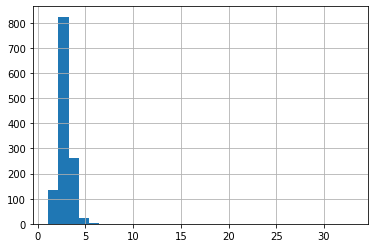

In [66]:
df['Density'].hist(bins=30)

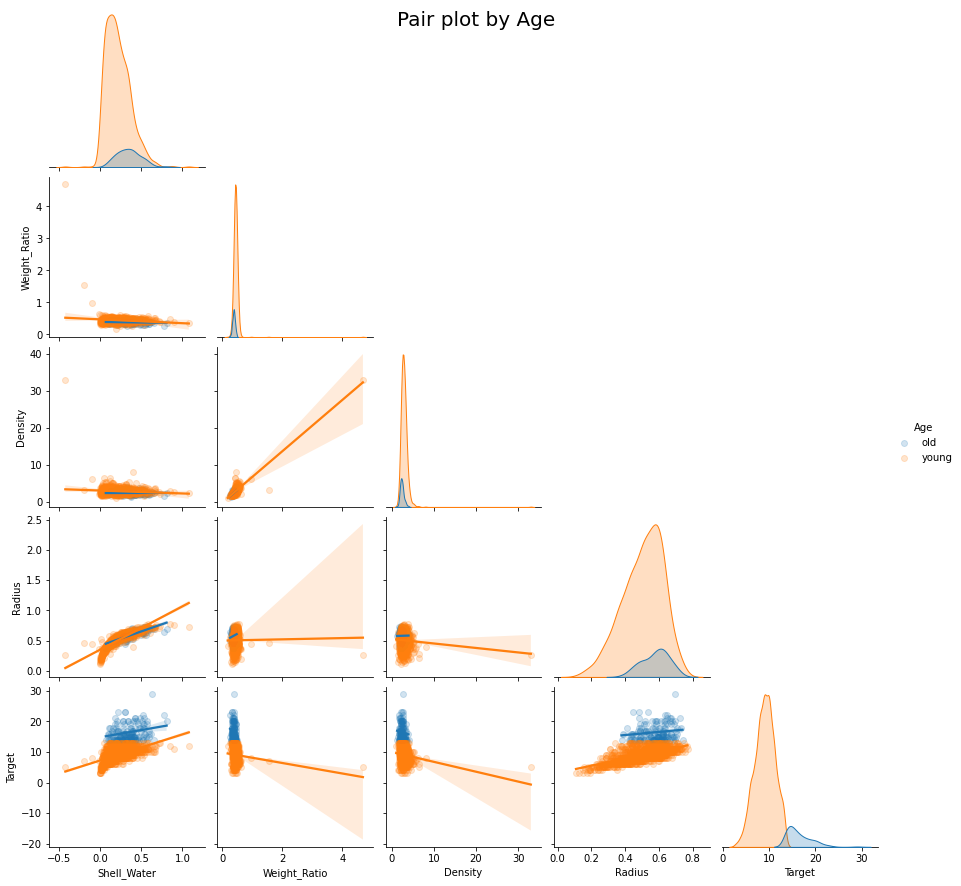

In [72]:
sns.pairplot(df.loc[:, ['Age', 'Shell_Water', 'Weight_Ratio', 'Density', 'Radius', 'Target']],
             hue='Age', kind='reg', corner=True, plot_kws={'scatter_kws': {'alpha': 0.2}})
plt.suptitle('Pair plot by Age', fontsize=20)
plt.show()

`-` 위를 보면 13살이 넘어가면 예측하기 힘들 것 같다(군집화 되어있지 않고 겹쳐있다)